In [517]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [519]:
#A função abaixo serve para baixar os dados da ação através de três paramêtros, o ticker da ação, a data de início do oeríodo de análise 
#e a data final do período de análise
def baixar_dados_acao(ticker, data_inicio, data_fim):
    dados_acao = yf.download(ticker, start=data_inicio, end=data_fim)
    return dados_acao

In [533]:
#A função sinais_media gera os sinais de compra e venda com base nas médias móveis de curto e longo prazo, definidas como 40 e 100 períodos, respectivamente
#A função pode atribuir 3 valores: 1, 0 e -1 
#O valor '1' representa um tom positivo do mercado, sinalizando compra
#O valor '0' representa um tom neutro, permanecendo o viés anterior
#O valor '-1' representa um tom negativo, sinalizando um viés de venda
def sinais_media(dados):
    sinais = pd.DataFrame(index=dados.index)
    sinais['sinal'] = 0.0

    # Criação de uma média móvel simples de curto prazo (40 períodos)
    sinais['MM40'] = dados['Close'].rolling(window=40, min_periods=1, center=False).mean()

    # Criação de uma média móvel simples de longo prazo (100 períodos)
    sinais['MM100'] = dados['Close'].rolling(window=100, min_periods=1, center=False).mean()

    # Gerar sinais de compra/venda
    sinais['sinal'][40:] = np.where(sinais['MM40'][40:] > sinais['MM100'][40:], 1.0, 0.0)  # Compra se MM40 > MM100

    # Identificar mudanças nos sinais
    sinais['posicoes'] = sinais['sinal'].diff()

    return sinais

In [545]:
if __name__ == "__main__":
    ticker = 'VALE3.sa'  #Ticker da Ação. Nota: Para ativos do IBOVESPA, adicionar .sa ao final do ticker.
    data_inicio = '2020-01-01' #Data de início
    data_fim = '2025-01-25'  #Data final

    # Baixar os dados históricos da ação
    dados = baixar_dados_acao(ticker, data_inicio, data_fim)

    # Gerar sinais com base nas médias móveis
    sinais = sinais_media(dados)

    # Adicionar as médias móveis e as posições ao DataFrame 'dados'
    dados['MM40'] = sinais['MM40']
    dados['MM100'] = sinais['MM100']
    dados['Posicoes_Alteradas'] = sinais['posicoes'] 
    dados.reset_index(inplace=True) #Criando um novo index, que anteriormente era a data
    dados.drop(columns=['High', 'Low', 'Open', 'Volume'], inplace=True) #Removendo colunas que não serão utilizadas. 
    

    # Identificar os pontos de cruzamento
    cruzamentos_compra = dados.loc[dados['Posicoes_Alteradas'] == 1]
    cruzamentos_venda = dados.loc[dados['Posicoes_Alteradas'] == -1]

[*********************100%***********************]  1 of 1 completed
C:\Users\jpmen\AppData\Local\Temp\ipykernel_3708\2745788470.py:17: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sinais['sinal'][40:] = np.where(sinais['MM40'][40:] > sinai

In [549]:
reversao = dados.loc[(dados['Posicoes_Alteradas'] == 1)] #Verificando quais momentos são apontados como viéses para compra
reversao

Price,Date,Close,MM40,MM100,Posicoes_Alteradas
Ticker,,VALE3.SA,,,
106,2020-06-05,34.998695,30.557531,30.460469,1.0
507,2022-01-19,69.284111,61.104877,60.902288,1.0
701,2022-10-27,60.834919,60.137417,60.027602,1.0
922,2023-09-15,63.022888,59.400430,59.394732,1.0
1099,2024-06-05,57.727123,60.750221,60.744104,1.0
1190,2024-10-10,60.708149,58.812322,58.735661,1.0


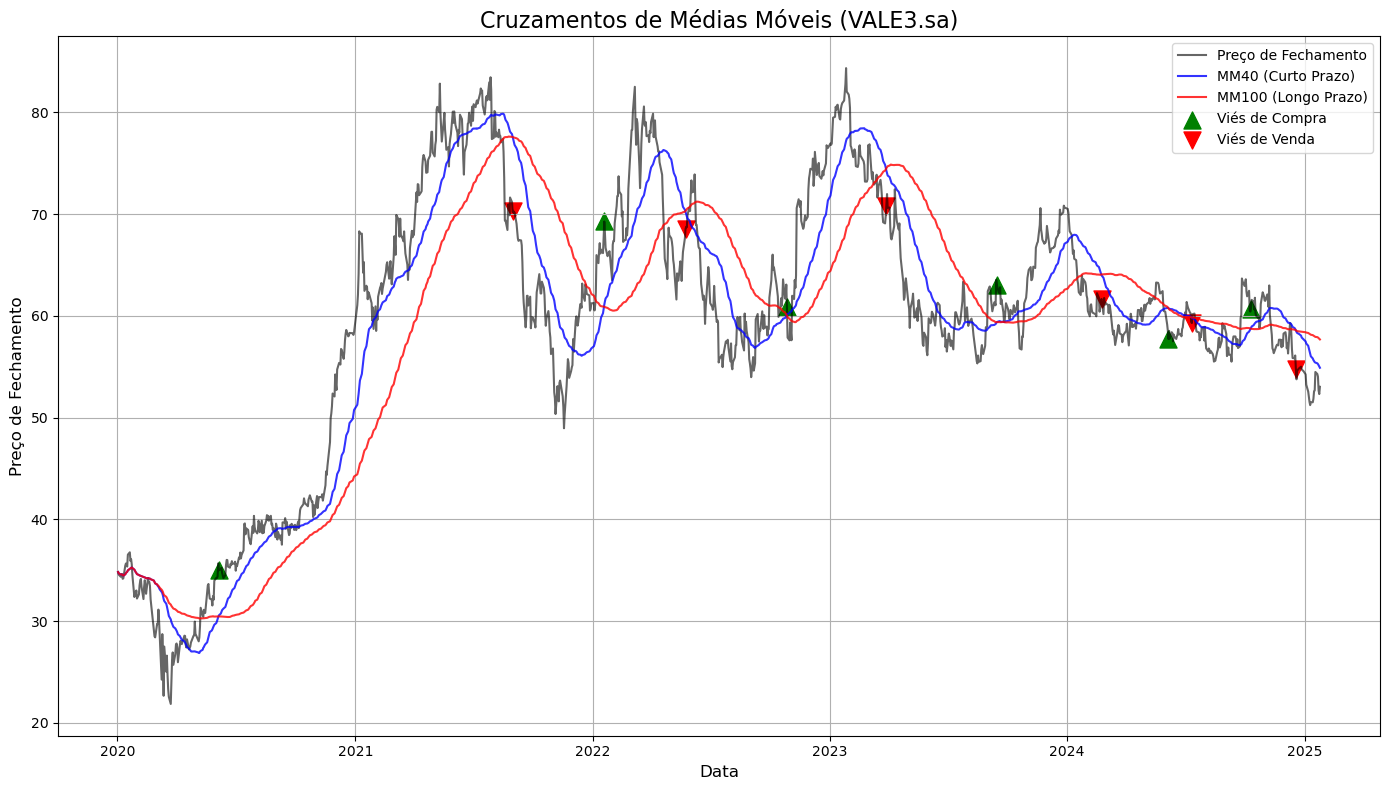

In [547]:
# Plotar o gráfico
plt.figure(figsize=(14, 8))
plt.plot(dados['Date'], dados['Close'], label='Preço de Fechamento', color='black', alpha=0.6)
plt.plot(dados['Date'], dados['MM40'], label='MM40 (Curto Prazo)', color='blue', alpha=0.8)
plt.plot(dados['Date'], dados['MM100'], label='MM100 (Longo Prazo)', color='red', alpha=0.8)

# Adicionar cruzamentos das médias no gráfico
plt.scatter(cruzamentos_compra['Date'], cruzamentos_compra['Close'], color='green', label='Viés de Compra', marker='^', s=150)
plt.scatter(cruzamentos_venda['Date'], cruzamentos_venda['Close'], color='red', label='Viés de Venda', marker='v', s=150)

# Configurações adicionais do gráfico, fontes, títulos.
plt.title(f'Cruzamentos de Médias Móveis ({ticker})', fontsize=16)
plt.xlabel('Data', fontsize=12)
plt.ylabel('Preço de Fechamento', fontsize=12)
plt.legend()    
plt.grid(True)
plt.tight_layout()

#Salvando o gráfico para análise
nome_arquivo = f"grafico_{ticker}.png"
plt.savefig(nome_arquivo, dpi=300)

# Mostrar o gráfico
plt.show()